# GOAL
To create a probabilistic decoder based on Etter...Williams (2020) Front Neural Circuits

Example:  using ZZ087 D28

In [1]:
# imports
import mat4py
import numpy as np
import pandas as pd
import scipy.stats as stats

import plotly.express as px
# this code is needed to make Plotly render in browser, because these plots don't work within Spyder Notebook IDE
import plotly.io as pio
# this line renders in browser and is interactive
# pio.renderers.default='browser'
# this line renders in Spyder and is static
pio.renderers.default='svg'

for this example, using ZZ138_D28 fiber photometry data

In [3]:
# load matlab data using loadmat. MATLAB data loaded as python dictionaries
beh_mat_file = r"C:\Users\Zach\Box\Zach_repo\Projects\Remote_memory\Miniscope data\PL_TeA\PL_TeA cohort1\bdbatch\ZZ087_caroc\ZZ087_D28\D28_analyzed\Behavior.mat"
ms_data_file = r"C:\Users\Zach\Box\Zach_repo\Projects\Remote_memory\Miniscope data\PL_TeA\PL_TeA cohort1\bdbatch\ZZ087_caroc\ZZ087_D28\minian_data_processed.mat"
frlu_file = r"C:\Users\Zach\Box\Zach_repo\Projects\Remote_memory\Miniscope data\PL_TeA\PL_TeA cohort1\bdbatch\ZZ087_caroc\ZZ087_D28\frlu.mat"

behdata = mat4py.loadmat(beh_mat_file)
ms_data = mat4py.loadmat(ms_data_file)
frlu_data = mat4py.loadmat(frlu_file)

In [4]:
# access data of interest
frz_vec = behdata["Behavior"]["Freezing"]["Vector"]
csp_vec = behdata['Behavior']['Temporal']['csp']['Vector']
csm_vec = behdata['Behavior']['Temporal']['csm']['Vector']

sig = ms_data['dff']
frlu = frlu_data['frlu']

# convert lists to arrays
frz_vec = np.array(frz_vec)
csp_vec = np.array(csp_vec)
csm_vec = np.array(csm_vec)
sig = np.array(sig)

In [5]:
# convert sig array to dataframe
#sigdf = pd.DataFrame(sig)
#sigdf = sigdf.T
#sig = sigdf

sig = np.transpose(sig)

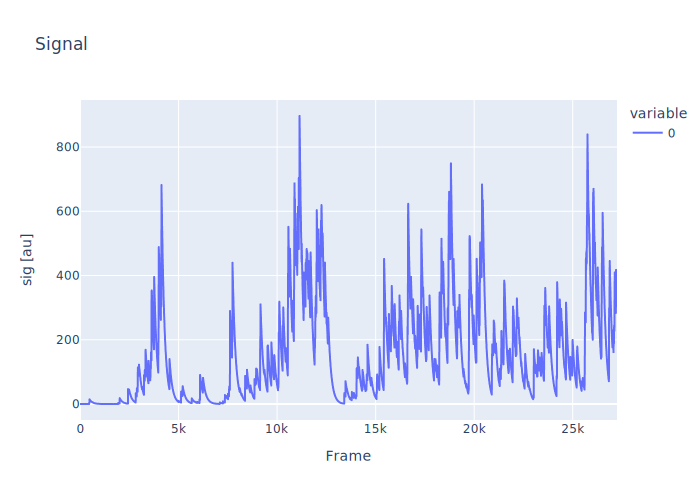

In [5]:
# generate some plots
fig = px.line(sig[:,0], title="Signal") 
fig.update_layout(xaxis_title="Frame", yaxis_title="sig [au]")
fig.show()

# Step 1:  Process signal
Goal is to filter high frequency activity, look for large (> 2SD) amplitude signals, then look for rising periods.
Signal periods satisfying those criteria are binarized.

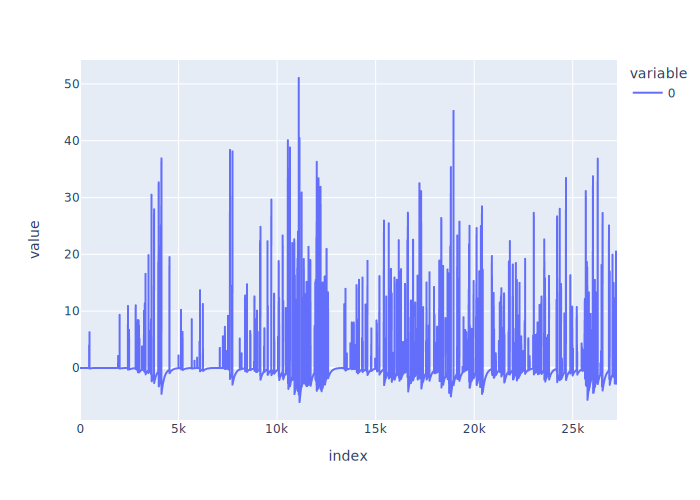

In [6]:
# find rising periods by looking for positive difference
sig_diff = np.diff(sig,axis=0)

# add an extra row to compensate for the off by 1 
tmp = np.ones(sig.shape[1])
sig_diff = np.vstack((sig_diff, tmp))

px.line(sig_diff[:,0])

In [7]:
# find indices that are positive, reflecting increase in signal

#pos_diff = [[i for i in range(len(sig_diff)) if sig_diff[i] > 0] for j in range(sig_diff.shape[1])]

pos_diff = np.zeros(sig_diff.shape)
for i in range(sig_diff.shape[1]): # for each cell
    for j in range(sig_diff.shape[0]):
        if sig_diff[j][i] > 0:
            pos_diff[j][i] = 1
            

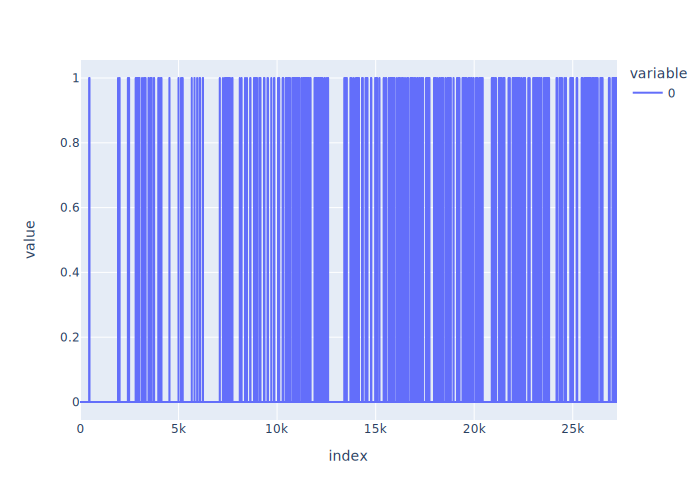

In [8]:
px.line(pos_diff[:,0])

In [9]:
# find indices with large (<2SD) signal 
#zscore signal
zsig = stats.zscore(sig)

# find large signals
big_sig = np.zeros(sig.shape)
for i in range(sig.shape[1]):
    for j in range(sig.shape[0]):
        if zsig[j][i] > 2:
            big_sig[j][i] = 1

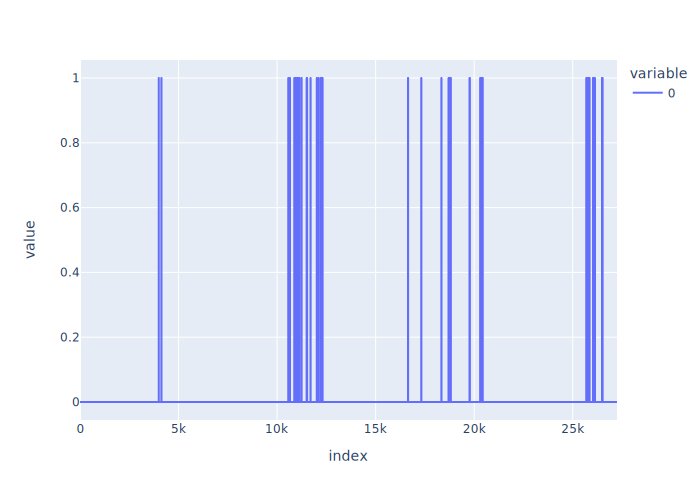

In [10]:
# find periods where sig is increasing AND sig is large
bin_sig = np.zeros(sig.shape)
bin_sig = pos_diff + big_sig
bin_sig[bin_sig<2] = 0
bin_sig[bin_sig==2] = 1

px.line(bin_sig[:,0])

# Step 2:  Calculate probabilities:  activity, behavior state, joint probability

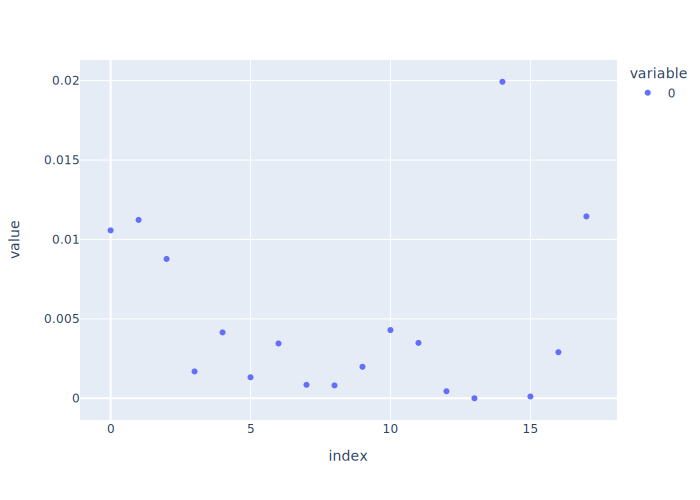

In [11]:
# calculate probability of neuron being active (marginal likelihood)
p_a = np.zeros(bin_sig.shape[1])
for i in range(bin_sig.shape[1]):
    p_a[i] = np.sum(bin_sig[:,i] / bin_sig.shape[0])

# visualize overall activity levels (y axis) of each neuron (x axis)
px.scatter(p_a)

In [12]:
# probability of behavior states (ie prior probability)
p_s_frz = np.sum(frz_vec) / frz_vec.shape[0]
p_s_csp = np.sum(csp_vec) / csp_vec.shape[0]
p_s_csm = np.sum(csm_vec) / csm_vec.shape[0]

### Interpolate calcium activity to match behavior frames

In [30]:
x_sigsize = np.arange(zsig.shape[0])
behsize = frz_vec.shape[0]
nn = zsig.shape[1]
zsig_orig = zsig
zsig = np.zeros([behsize,nn])
for i in range(zsig.shape[1]):
    y = zsig[:,i]
    interp = interpolate.interp1d(x_sigsize,y, kind='cubic') # create the interporlation function, cubic is good
    xnew = np.linspace(0, zsig.shape[0]-1, num=behsize) # linspace to create a vector evenly spaced in sig size, but stretched with points to match beh size
    zsig[:,i] = xnew

ValueError: x and y arrays must be equal in length along interpolation axis.

In [24]:
# calculate joint probability
psa_frz = np.zeros(bin_sig.shape[1])
for i in range(bin_sig.shape[1]):
    tmp = frz_vec + bin_sig[:,i]
    tmp[tmp<2] = 0
    tmp[tmp==2] = 1
    psa_frz[i] = np.sum(tmp) / bin_sig.shape[0]

ValueError: operands could not be broadcast together with shapes (34462,) (27247,) 

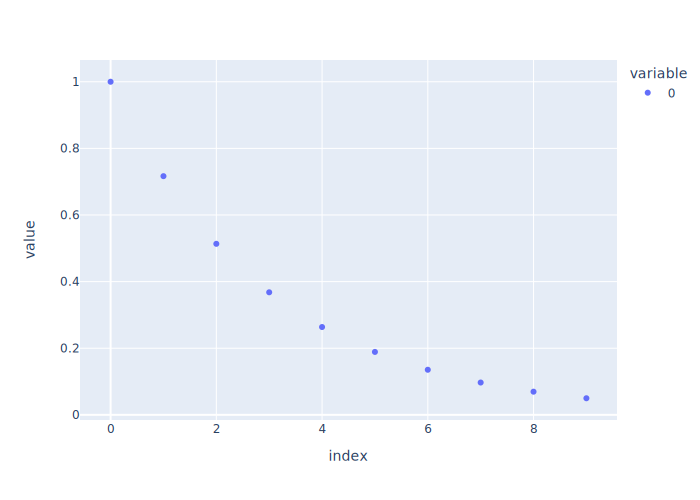

In [13]:
from scipy import interpolate
x = np.arange(0, 10)
y = np.exp(-x/3.0)
z = interpolate.interp1d(x, y, kind = "cubic")
y_cubic = z(x)

fig = px.scatter(y_cubic)
fig.show()

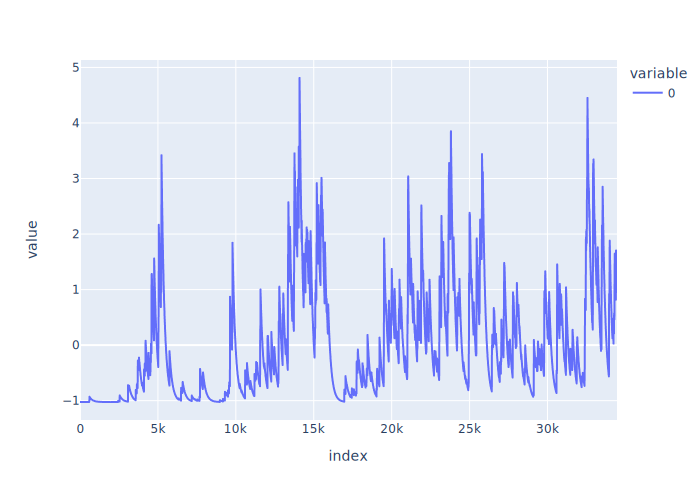

In [14]:
x_sigsize = np.arange(zsig.shape[0])
x_behsize = np.arange(frz_vec.shape[0])
y = zsig[:,0]

# create the interporlation function, cubic is good
interp = interpolate.interp1d(x_sigsize,y, kind='cubic')

# linspace to create a vector evenly spaced in sig size, but stretched with points to match beh size
xnew = np.linspace(0, zsig.shape[0]-1, num=frz_vec.shape[0])

# create 
ynew = interp(xnew)
px.line(ynew)